# ABS Quarterly National Accounts 5206

Expenditure approach: $GDP(E) = C + I + G + NX$

Income approach: $GDP(I) = CompensationOfEmployees + RentalAndRoyaltyIncome + BusinessCashFlow + NetInterest$

Output or product approach: $GDP(O) = (GrossValueAdded + TaxesOnProducts - SubsidiesOnProducts) - IntermediateConsumption + TaxesOnProducts - SubsidiesOnProducts$

## Python set-up

In [1]:
# system imports
import re
import sys

# analytic imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from abs_data_capture import (
    find_id,
    find_rows,
    fix_abs_title,
    AbsLandingPage,
    get_abs_data,
    get_fs_constants,
    get_identifier,
    metacol,
    get_plot_constants,
    get_abs_series,
    plot_summary,
)

# local imports
from henderson import hma
from plotting import (
    calc_growth,
    clear_chart_dir,
    finalise_plot,
    line_plot,
    plot_covid_recovery,
    plot_growth_finalise,
    recalibrate_series,
    set_chart_dir,
)

# pandas display settings
pd.options.display.max_rows = 999999
pd.options.display.max_columns = 999

# display charts within this notebook
SHOW = False

## Get data from ABS

In [2]:
landing_page = AbsLandingPage(
    theme="economy",
    parent_topic="national-accounts",
    topic="australian-national-accounts-national-income-expenditure-and-product",
)
abs_dict = get_abs_data(landing_page)
source, CHART_DIR, Cat_ID, meta = get_fs_constants(abs_dict, landing_page)
RECENT, plot_times, plot_tags = get_plot_constants(meta)

In [3]:
# extract meta data, etc.
CVM = "Chain volume measures"
value_text = "$ Millions"

## Plot

### Plot setup

In [4]:
plt.style.use("fivethirtyeight")
clear_chart_dir(CHART_DIR)
set_chart_dir(CHART_DIR)

### Summary plot

A2323382F 1 Household saving ratio: Ratio ; Seasonally Adjusted
A2303940R 5 Households ;  Final consumption expenditure ; Seasonally Adjusted
A2303940R 5 Households ;  Final consumption expenditure ; Seasonally Adjusted
A2303730T 5 GROSS DOMESTIC PRODUCT ; Seasonally Adjusted
A2303730T 5 GROSS DOMESTIC PRODUCT ; Seasonally Adjusted
A2304080V 2 General government ;  Final consumption expenditure ; Seasonally Adjusted
A2304080V 2 General government ;  Final consumption expenditure ; Seasonally Adjusted
A2304081W 2 Households ;  Final consumption expenditure ; Seasonally Adjusted
A2304081W 2 Households ;  Final consumption expenditure ; Seasonally Adjusted
A3606056V 1 Gross value added market sector: Chain volume measures ; Seasonally Adjusted
A3606056V 1 Gross value added market sector: Chain volume measures ; Seasonally Adjusted
A2304404C 1 GDP per capita: Chain volume measures ; Seasonally Adjusted
A2304404C 1 GDP per capita: Chain volume measures ; Seasonally Adjusted
A2304402X 1 Gros

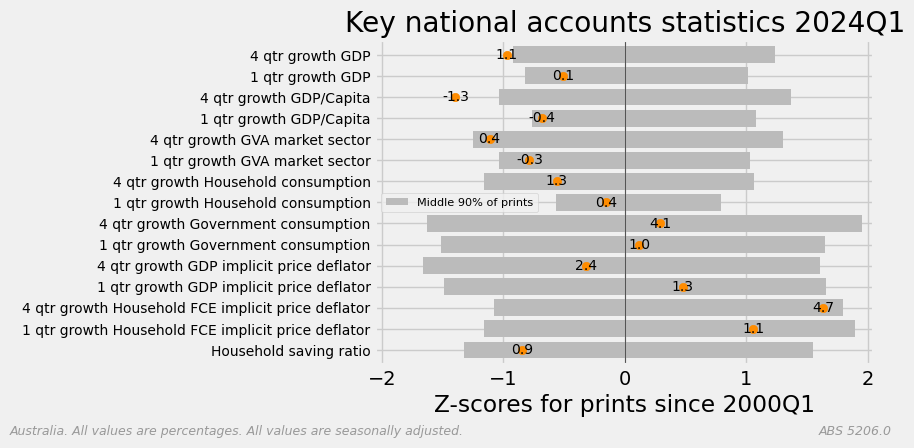

In [13]:
required  = {
    # order from least to most important (ie. bottom to top)
    # chart label: [ABS code, growth over n periods]
    "Household saving ratio": ["A2323382F", 0],
    "1 qtr growth Household FCE implicit price deflator": ["A2303940R", 1],
    "4 qtr growth Household FCE implicit price deflator": ["A2303940R", 4],
    "1 qtr growth GDP implicit price deflator": ["A2303730T", 1],
    "4 qtr growth GDP implicit price deflator": ["A2303730T", 4],
    "1 qtr growth Government consumption": ["A2304080V", 1],
    "4 qtr growth Government consumption": ["A2304080V", 4],
    "1 qtr growth Household consumption": ["A2304081W", 1],
    "4 qtr growth Household consumption": ["A2304081W", 4],

    "1 qtr growth GVA market sector": ["A3606056V", 1],
    "4 qtr growth GVA market sector": ["A3606056V", 4],
    "1 qtr growth GDP/Capita": ["A2304404C", 1],
    "4 qtr growth GDP/Capita": ["A2304404C", 4],
    "1 qtr growth GDP": ["A2304402X", 1],
    "4 qtr growth GDP": ["A2304402X", 4],
    }

start = "2000Q1"
plot_summary(
    required, 
    abs_dict, 
    meta,
    start=start,
    title=f"Key national accounts statistics {abs_dict['2'].index[-1]}",
    rfooter=source,
    lfooter="Australia. All values are percentages. "
    "All values are seasonally adjusted. ",
    show=True,
)


### Growth charts - based on seasonally adjusted series

In [5]:
def growth_charts() -> None:
    # identify available headline series from metadata
    table = "1"
    data = abs_dict[table]

    series_type = "Seasonally Adjusted"
    rows = meta[
        (meta[metacol.table] == table)
        & (meta[metacol.stype] == series_type)
        & (meta[metacol.unit].isin([value_text, "$"]))
        & (meta[metacol.did].str.contains(CVM))
    ]

    for index, row in rows.iterrows():
        # identify data
        series_id, units, title = row[metacol.id], row[metacol.unit], row[metacol.did]
        series, units = recalibrate_series(data[series_id], units, verbose=True)
        units = f"{units} / Quarter"  # make time frame explicit
        lfooter = f"Australia. {series_type}. "
        title, lfooter = fix_abs_title(title, lfooter)
        series.name = title.replace(":", "").strip()

        common = {
            "rfooter": f"{source} {table}",
            "lfooter": lfooter,
        }

        # plot
        line_plot(
            series,
            dropna=True,
            starts=plot_times,
            tags=plot_tags,
            title=title,
            ylabel=units,
            pre_tag="raw-charts-",
            show=SHOW,
            width=2,
            **common,
        )

        plot_covid_recovery(
            series,
            title=title,
            ylabel=f"{units}",
            tags="covid-qtr",
            rfooter=f"{source} {table}",
            lfooter=lfooter,
            show=SHOW,
        )

        growth = calc_growth(series)
        print(f"Last {title} growth: ", [g.iloc[-1] for g in growth])
        for start, tag in zip(plot_times, plot_tags):
            plot_growth_finalise(
                *growth,
                from_=start,
                tag=tag,
                title=f"{title} growth",
                pre_tag="growth-charts-",
                show=SHOW and start is not None,
                annotate=True,
                **common,
            )


growth_charts()

Last Gross domestic product: growth:  [1.1111829036549503, 0.12747715009000515]
Last GDP per capita: growth:  [-1.26765505746117, -0.44230173824584273]
Last Gross value added market sector: growth:  [0.38337945842199517, -0.2727747670098979]
Last Net domestic product: growth:  [0.7789375292101441, 0.013280080869737532]
Last Real gross domestic income: growth:  [-0.8739326971371142, 0.17457176663631113]
Last Real gross national income: growth:  [0.0555340640447044, -0.008247479364120736]
Last Real net national disposable income: growth:  [-0.4990602112904252, -0.1523168526219032]
Last Real net national disposable income per capita: growth:  [-2.8395881766854814, -0.7183257918552011]


### Long run annual GDP Growth - using a Henderson moving average

In [6]:
def chart_gdp_long_run_growth(chart: str) -> None:
    # key data sources
    table = "1"
    data = abs_dict[table]
    series_type = "Seasonally Adjusted"

    # select series
    selector = {
        table: metacol.table,
        chart: metacol.did,
        series_type: metacol.stype,
        CVM: metacol.did,
        "$": metacol.unit,
    }
    id, units = find_id(meta, selector, verbose=False)

    # plot original
    ax = None  # so we can comment out a plot code-line
    q_gdp = data[id].dropna()
    series = (q_gdp.pct_change(periods=4, fill_method=None) * 100).dropna()
    ax = series.plot(color="darkblue", lw=0.5, ls="-", ax=ax, label="Annual growth")

    # plot Henderson Moving Average
    HENDERSON_N = 13  # months ==> multi-year Henderson moving average
    smoothed = hma(series, HENDERSON_N)
    ax = smoothed.plot(
        color="darkorange",
        lw=1.5,
        ls="-",
        ax=ax,
        label=f"{HENDERSON_N}-term Henderson moving average",
    )

    # plot decadal averages
    decades = series.index.year.astype(str).str[2:3].unique()
    label = "Decadal mean (DM) annual growth"
    for decade in decades:
        d_series = series[series.index.year.astype(str).str[2:3] == decade]
        d_series = pd.Series(
            np.repeat(d_series.mean(), len(d_series)), index=d_series.index
        )
        ax = d_series.plot(color="darkred", lw=2, ls="--", ax=ax, label=label)
        label = None
        ax.text(
            x=d_series.index[-1],
            y=series.min(),
            s=f"DM = {d_series.iloc[-1]:0.2f}%",
            rotation=90,
            ha="center",
            size="x-small",
        )

    # plot compound annual growth rate over a decade
    YEARS = 10
    PERIODS_PER_YEAR = 4
    annual = (
        ((q_gdp / q_gdp.shift(YEARS * PERIODS_PER_YEAR)) ** (1 / YEARS)) - 1
    ) * 100
    ax = annual.plot(
        color="dodgerblue",
        lw=3,
        ls="-",
        ax=ax,
        label="Annual compound growth over decade",
    )

    # finalise the plot
    ax.legend(loc="best", prop={"size": "x-small"})
    title = f"YoY Growth - {chart} - Long-run trends"
    finalise_plot(
        ax,
        title=title,
        ylabel="Per cent / year",
        rfooter=f"{source} {table}",
        lfooter=f"Australia. {series_type.capitalize()}. "
        f"{CVM}. Compared with the same quarter in the previous year.",
        pre_tag="long-run-growth-",
        y0=True,
        show=SHOW,
    )

In [7]:
def do_long_run_charts():
    charts = [
        "Gross domestic product",
        "GDP per capita",
    ]
    for chart in charts:
        chart_gdp_long_run_growth(chart)


do_long_run_charts()

### Four quarter rolling totals - original series

In [8]:
def rolling_totals() -> None:
    table = "1"
    data = abs_dict[table]
    series_type = "Original"

    charts = [
        "Gross domestic product",
        "GDP per capita",
    ]
    for chart in charts:
        selector = {
            table: metacol.table,
            chart: metacol.did,
            series_type: metacol.stype,
            CVM: metacol.did,
            "$": metacol.unit,
        }
        id, units = find_id(meta, selector, verbose=False)
        rolling4Q = data[id].rolling(4).sum()
        # units = "$ Number" if units == "$" else units
        rolling4Q, units = recalibrate_series(rolling4Q, units)
        rolling4Q.name = chart

        title = meta.loc[meta[metacol.id] == id, metacol.did].iloc[0]
        lfooter = f"Australia. 4Q rolling sum. {series_type} series. "
        title, lfooter = fix_abs_title(title, lfooter)
        plot_covid_recovery(
            rolling4Q,
            title=title,
            ylabel=f"{units} / year",
            tags="covid-annual",
            rfooter=f"{source} {table}",
            lfooter=lfooter,
            pre_tag="4Qrolling-",
            show=SHOW,
        )


rolling_totals()

### Implicit population estimates

In [9]:
def pop_estimates() -> None:
    table = "1"
    data = abs_dict[table]
    series_type = "Seasonally Adjusted"

    pairs = {
        # $                                         $ Millions
        (
            "GDP per capita: Chain volume measures ;",
            "Gross domestic product: Chain volume measures ;",
        ),
        (
            "GDP per capita: Current prices ;",
            "Gross domestic product: Current prices ;",
        ),
    }

    pop_series = []
    for pair in pairs:
        data_items = []
        for index, series in enumerate(pair):
            selector = {
                table: metacol.table,
                series_type: metacol.stype,
                series: metacol.did,
            }
            id, units = find_id(meta, selector)  # , verbose=True)
            data_items.append(data[id])
        series = data_items[1] / data_items[0]
        pop_series.append(series)
    pop_series = pd.DataFrame(pop_series).T.mean(axis="columns").dropna()
    pop_series.name = "Australian population"

    title = "Implicit population from ABS National Accounts"
    common = {
        "rfooter": f"{source} {table}",
        "lfooter": "Australia. Calculated. ",
        "show": SHOW,
    }
    plot_covid_recovery(
        pop_series,
        title=title,
        ylabel=f"Millions",
        tags="covid",
        **common,
    )

    growth = calc_growth(pop_series)
    growth2 = []
    growth2.append(pop_series.diff(periods=4) * 1000)
    growth2.append(pop_series.diff(periods=1) * 1000)

    new_title = title.replace("population", "pop. growth")
    for start, tag in zip(plot_times, plot_tags):
        plot_growth_finalise(
            *growth,
            from_=start,
            tag=tag,
            title=new_title,
            pre_tag="population-percent-",
            annotate=True,
            **common,
        )
        plot_growth_finalise(
            *growth2,
            from_=start,
            tag=tag,
            ylabel="Thousands",
            title=new_title,
            pre_tag="population-change-",
            annotate=False,
            **common,
        )


pop_estimates()

### Implicit price deflators

In [10]:
def price_deflators() -> dict:
    table = "5"
    data = abs_dict[table]

    keys = {
        "GDP": "GROSS DOMESTIC PRODUCT ;",
        "HFCE": "Households ;  Final consumption expenditure ;",
    }

    deflators = {}  # used in calculations below ...
    for prefix, key in keys.items():
        ident = meta[(meta[metacol.did] == key) & (meta[metacol.table] == table)][
            metacol.id
        ].iloc[0]
        series = data[ident].dropna()
        print(series.tail())
        deflators[prefix] = series / series.iloc[-1]  # rebase
        growth = series.pct_change(4, fill_method=None) * 100
        title = f"Growth in the {prefix} Implicit Prices"

        line_plot(
            growth,
            title=title,
            ylabel="Growth: Per cent per year",
            rfooter=f"{source} {table}",
            lfooter="Calculated from the seasonally adjusted index",
            y0=True,
            pre_tag="deflators-",
            width=2,
            show=SHOW,
        )

    return deflators


deflators = price_deflators()

Series ID
2023Q1    107.9
2023Q2    106.7
2023Q3    107.8
2023Q4    109.1
2024Q1    110.5
Freq: Q-DEC, Name: A2303730T, dtype: float64
Series ID
2023Q1    107.3
2023Q2    108.6
2023Q3    110.3
2023Q4    111.1
2024Q1    112.3
Freq: Q-DEC, Name: A2303940R, dtype: float64


#### Unit Labour Cost growth

In [11]:
def get_ulc() -> None:
    """Annual unit labour costs growth."""

    source = "5206.0"
    series_ids = ["A2304402X", "A2302915V"]
    nat_accounts_meta, nat_accounts = get_abs_series(
        cat_id=source, series_ids=series_ids
    )
    display(nat_accounts_meta)
    ulc = nat_accounts["A2302915V"] / nat_accounts["A2304402X"]
    
    common = {
        "rfooter": f"{source}: {', '.join(series_ids)}",
        "lfooter": "Australia. Seasonally adjusted. ",
        "ylabel": "Per cent growth",
        "show": SHOW,
    }

    growth = calc_growth(ulc)
    plot_growth_finalise(
        *growth,
        title="Unit Labour Costs Growth",
        from_=RECENT,
        tag="growth",
        annotate=True,
        **common,
    )

    line_plot(
        growth[0], 
        title="Unit Labour Costs Growth (YoY)", 
        width=2,
        y0=True,
        **common,
    )


get_ulc()

,A2304402X,A2302915V
Data Item Description,Gross domestic product: Chain volume measures ;,Compensation of employees ;
Series Type,Seasonally Adjusted,Seasonally Adjusted
Series ID,A2304402X,A2302915V
Series Start,1959-09-01 00:00:00,1959-09-01 00:00:00
Series End,2024-03-01 00:00:00,2024-03-01 00:00:00
No. Obs.,259.0,259.0
Unit,$ Millions,$ Millions
Data Type,DERIVED,DERIVED
Freq.,Quarter,Quarter
Collection Month,3.0,3.0


#### Check deflator accuracy

In [12]:
def check_deflator_accuracy():
    table = "5"
    data = abs_dict[table]
    row = meta[
        (meta[metacol.table] == table)
        & meta[metacol.did].str.contains("[Pp]ercent")
        & meta[metacol.did].str.contains("GROSS DOMESTIC PRODUCT")
    ]
    id = row[metacol.id].values[0]
    series = (data[id] / 100 + 1).cumprod()
    series.iloc[0] = 1.0
    series = series / series.iloc[-1]
    print((series - deflators["GDP"]).mean())


check_deflator_accuracy()

-0.0010176807663406216


### Savings - current prices and GDP-deflator adjusted

In [13]:
def savings(deflators: dict) -> None:
    table = "11"
    data = abs_dict[table]
    series_type = "Seasonally Adjusted"
    series_focus = "Net saving"

    headline_plots = meta[
        (meta[metacol.table] == table)
        & (meta[metacol.stype] == series_type)
        & (meta[metacol.did].str.contains(series_focus))
    ][metacol.did]

    for description in headline_plots:
        # identify data
        series, units = get_identifier(meta, description, series_type, table)
        units = f"{units} / Qtr"
        plotable, units = recalibrate_series(data[series].dropna(), units)
        title = description.replace(" ;", "").replace("  ", " ").capitalize()

        common = {
            "title": title,
            "y0": True,
            "rfooter": f"{source} {table}",
            "pre_tag": "saving-",
            "show": SHOW,
        }
        lfooter = f"Australia. {series_type.capitalize()} series. Current prices. "

        line_plot(
            plotable,
            starts=plot_times,
            tags=plot_tags,
            lfooter=lfooter,
            ylabel=units,
            width=2,
            **common,
        )

        for deflator in deflators:
            plotable = (plotable / deflators[deflator]).dropna()
            plotable.name = "Series"
            plot_covid_recovery(
                plotable,
                tags=f"covid-{deflator}",
                lfooter=f"{lfooter}Prices adjusted by {deflator} deflator. ",
                ylabel=f"{units} (inflation adj)",
                **common,
            )


savings(deflators)

### Gross Value Added (GVA) by Industry

In [14]:
def gva_by_industry() -> None:
    # identify available series from metadata
    table = "6"
    data = abs_dict[table]

    series_type = "Seasonally Adjusted"
    industries = meta[
        (meta[metacol.table] == table)
        & (meta[metacol.stype] == series_type)
        & (meta[metacol.unit] == value_text)  # limit to money
    ][metacol.did]
    industry_start = pd.Period("1974-09-01", freq="Q")

    for industry in industries:
        # get data
        selector = {
            table: metacol.table,
            series_type: metacol.stype,
            industry: metacol.did,
        }

        id, units = find_id(meta, selector, exact=True, verbose=False)
        units = f"{units}  / Quarter"
        series, units = recalibrate_series(data[id].dropna(), units)

        title = industry.replace(" ;", "").strip()
        if not title.endswith(")"):
            title = re.sub(r"^[^\(]+\(", "(", title)
        title = f" GVA: {title}"

        line_plot(
            series,
            starts=plot_times,
            tags=plot_tags,
            title=title,
            ylabel=units,
            rfooter=f"{source} {table}",
            lfooter=(f"{series_type.capitalize()}, " f"{CVM.lower()}"),
            pre_tag="gva-",
            width=2,
            show=SHOW,  # SHOW,
        )


gva_by_industry()

###  Household Final Consumption Expenditure

In [15]:
def hfce() -> tuple[pd.Series, str]:
    # identify available series from metadata
    table = "8"
    data = abs_dict[table]
    series_type = "Seasonally Adjusted"
    hfce_selected = meta[
        (meta[metacol.table] == table)
        & (meta[metacol.stype] == series_type)
        & (meta[metacol.unit] == "$ Millions")
        & (meta[metacol.did].str.contains(CVM))  # limit to money
    ][metacol.did]

    for description in hfce_selected:
        # get data
        series, units = get_identifier(meta, description, series_type, table)
        units = f"{units} / Quarter"
        plotable, units = recalibrate_series(data[series].dropna(), units)
        plotable.name = f"{series_type.capitalize()} series"
        title = description.replace(f": {CVM} ;", "")
        separator = "\n" if len(title) > 25 else " "
        title = f"Household consumption:{separator}{title}"

        common = {
            "title": title,
            "ylabel": units,
            "rfooter": f"{source} {table}",
            "lfooter": f"Australia. {CVM.capitalize()} ",
            "pre_tag": "hfce-",
            "show": SHOW,
        }

        # plot - complete series - and recent showing covid recoverhy
        line_plot(
            plotable,
            width=2,
            **common,
        )

        plot_covid_recovery(
            plotable,
            tags="covid",
            **common,
        )

        growth = calc_growth(plotable)
        plot_growth_finalise(
            *growth,
            from_=RECENT,
            tag="growth",
            annotate=True,
            **(common | {"ylabel": "Per cent growth"}),
        )

        # remember HFCE for next cell ...
        if "FINAL CONSUMPTION EXPENDITURE" in description:
            HFCE_q_series = plotable
            HFCE_q_units = units

    return HFCE_q_series, HFCE_q_units


HFCE_q_series, HFCE_q_units = hfce()

In [16]:
def quarterly_gdp() -> tuple[pd.Series, str]:
    table = "1"
    data = abs_dict[table]
    series_type = "Seasonally Adjusted"
    item = "Gross domestic product"

    selector = {
        table: metacol.table,
        item: metacol.did,
        series_type: metacol.stype,
        CVM: metacol.did,
        "$": metacol.unit,
    }
    id, units = find_id(meta, selector, verbose=False)
    series = data[id]
    return recalibrate_series(series, units)


GDP_q_series, GDP_q_units = quarterly_gdp()

In [17]:
def hfce_percent_gdp(HFCE_q_series, GDP_q_series):
    HFCE_proportion = HFCE_q_series / GDP_q_series * 100
    line_plot(
        HFCE_proportion,
        title="HFCE as a proportion of GDP",
        ylabel="Per cent",
        rfooter=f"{source} 1, 8",
        lfooter=(f"Seasonally adjusted series. {CVM.lower()}"),
        pre_tag="hfce-",
        width=2,
        show=SHOW,
    )
    print(HFCE_proportion.mean())


hfce_percent_gdp(HFCE_q_series, GDP_q_series)

49.24332264114008


### Taxes

In [18]:
def taxes():
    # identify available series from metadata
    table = "22"
    data = abs_dict[table]
    series_type = "Seasonally Adjusted"
    tax_plots = meta[
        (meta[metacol.table] == table) & (meta[metacol.stype] == series_type)
    ][metacol.did]

    for plot in tax_plots:
        # data capture
        ident, units = get_identifier(meta, plot, series_type, table)
        units = f"{units} / Quarter"
        series, units = recalibrate_series(data[ident], units)

        # plot
        title = plot.replace(" ;", "")
        line_plot(
            series,
            starts=RECENT,
            title=title,
            ylabel=units,
            rfooter=f"{source} {table}",
            lfooter=f"Australia. {series_type.capitalize()} series. Current Prices.",
            pre_tag="taxes-",
            width=2,
            show=SHOW,
        )


taxes()

### Household income

In [19]:
def disposable_income():
    # Household gross disposable income = The amount of income
    # that households have available for spending after deducting
    # any taxes paid, interest payments and transfers overseas.

    table = "20"  # Table 20. Household Income Account, Current prices
    data = abs_dict[table]

    series_type = "Seasonally Adjusted"
    price_type = "Current prices"
    items = "GROSS DISPOSABLE INCOME", "TOTAL GROSS INCOME"
    series = []
    for item in items:
        id = meta[
            (meta[metacol.table] == table)
            & (meta[metacol.stype] == series_type)
            & (meta[metacol.did].str.contains(item))
            & (meta[metacol.tdesc].str.contains(price_type))
        ][metacol.id].iloc[0]
        series.append(data[id])
    percent_di = series[0] / series[1] * 100

    line_plot(
        percent_di,
        starts=(None, RECENT),
        title=f'Households: {" / ".join(items).title()}',
        ylabel="Per cent",
        rfooter=f"{source} {table}",
        lfooter=f"Australia. {series_type.capitalize()} series. "
        f"{price_type.capitalize()}. ",
        pre_tag="household_income-",
        width=2,
        show=SHOW,
    )


disposable_income()

In [20]:
def tax_percent_income():
    # Gross Total Individual Income Tax / Gross Total Household Income

    # Common
    series_type = "Seasonally Adjusted"
    price_type = "Current prices"

    # Total Gross Household Income
    table = "20"  # Table 20. Household Income Account, Current prices
    tables = [table]
    data = abs_dict[table]
    data_desc = "TOTAL GROSS INCOME"

    tghi_id = meta[
        (meta[metacol.table] == table)
        & (meta[metacol.stype] == series_type)
        & (meta[metacol.did].str.contains(data_desc))
        & (meta[metacol.tdesc].str.contains(price_type))
    ][metacol.id].iloc[0]
    tghi = data[tghi_id]

    # Total Income Taxes on Individuals
    table = "22"  # Table 22. Taxes, Current prices
    tables.append(table)
    data = abs_dict[table]
    data_desc = "Taxes on income - Individuals - Total"
    titi_id = meta[
        (meta[metacol.table] == table)
        & (meta[metacol.stype] == series_type)
        & (meta[metacol.did].str.contains(data_desc))
        & (meta[metacol.tdesc].str.contains(price_type))
    ][metacol.id].iloc[0]
    titi_id
    titi = data[titi_id]

    # Percent tax
    percent_tax = titi / tghi * 100
    line_plot(
        percent_tax,
        starts=(None, RECENT),
        title="Gross Individual Income Tax / Gross Household Income",
        ylabel="Per cent",
        rfooter=f"{source} {', '.join(tables)}",
        lfooter=f"Australia. {series_type.capitalize()} series. "
        f"{price_type.capitalize()}. ",
        pre_tag="taxes-",
        width=2,
        show=SHOW,
    )


tax_percent_income()

### Analytic

In [21]:
def household_expenditure():
    table = "24"  # Table 24. Selected Analytical Series
    data = abs_dict[table]

    # --- Household consumption CVM
    series_type = "Seasonally Adjusted"
    cut = "Households ;  Final consumption expenditure - "

    selector = {
        table: metacol.table,
        series_type: metacol.stype,
        "Household": metacol.did,
        CVM: metacol.did,
        "$": metacol.unit,
    }
    rows = find_rows(meta, selector, verbose=False)
    for index, row in rows.iterrows():
        id = row[metacol.id]
        units = row[metacol.unit]
        series = data[id].dropna()
        title = row[metacol.did].replace(cut, "").replace(CVM, "").replace(":  ;", "")
        series, units = recalibrate_series(series, units)
        series.name = title
        plot_covid_recovery(
            series,
            title=f"Household expenditure: {title}",
            ylabel=units,
            rfooter=f"{source} {table}",
            lfooter=f"Australia. {series_type.capitalize()} series. {CVM.capitalize()}. ",
            pre_tag="analytic-",
            show=SHOW,
        )


household_expenditure()

### Government Benefits Payments

In [22]:
def benefits():
    table = "23"
    data = abs_dict[table]
    series_type = "Original"

    plots_payments = meta[
        (meta[metacol.table] == table) & (meta[metacol.stype] == series_type)
    ][metacol.did]

    for plot in plots_payments:
        # get data
        ident, units = get_identifier(meta, plot, series_type, table)
        units = f"{units} / Quarter"
        series = data[ident].dropna()
        series, units = recalibrate_series(series, units)

        # plot
        title = plot.replace("General government - National ;  ", "Federal Govt - ")
        title = title.replace(
            "General government - State and local ;  ", "State or Local Govt - "
        )
        title = title.replace("General government ;  ", "All Govt - ")
        title = title.replace(" ;", "")
        line_plot(
            series,
            starts=RECENT,
            title=title,
            pre_tag="payments-",
            ylabel=f"{units}",
            rfooter=f"{source} {table}",
            lfooter=f"Australia. {series_type.capitalize()} series. Current prices.",
            width=2,
            show=SHOW,
        )


benefits()

### Total Wages v Total Profit

In [23]:
def profits():
    wages_table = "7"
    series_type = "Seasonally Adjusted"  # 'Original'
    wages_id, wage_units = find_id(
        meta,
        {
            wages_table: metacol.table,
            series_type: metacol.stype,
            "Compensation of employees ;": metacol.did,
        },
        exact=True,
        verbose=False,
    )
    wages = abs_dict[wages_table][wages_id]

    income_table = "7"
    tf_income_id, tf_income_units = find_id(
        meta,
        {
            income_table: metacol.table,
            series_type: metacol.stype,
            "Total factor income ;": metacol.did,
        },
        exact=True,
        verbose=False,
    )
    tf_income = abs_dict[income_table][tf_income_id]

    if wage_units != tf_income_units:
        raise ValueError

    profit_share_table = "24"
    profit_ratio_id, share_units = find_id(
        meta,
        {
            profit_share_table: metacol.table,
            "Seasonally Adjusted": metacol.stype,
            "Profits share of total factor income: Ratio ;": metacol.did,
        },
        exact=True,
        verbose=False,
    )
    profit_tfi_share = abs_dict[profit_share_table][profit_ratio_id] / 100
    profits = profit_tfi_share * tf_income

    # plot shares
    profit_wage_share = profits / (profits + wages) * 100
    hma_term = 7
    trend = hma(profit_wage_share, hma_term)
    df = pd.DataFrame(
        {
            "Profit share": profit_wage_share,
            "Henderson moving avergae": trend,
        }
    )
    line_plot(
        df,
        width=[1, 3],
        title="Profits as a share of profits plus wages",
        ylabel="Per cent",
        rfooter=f"{source} Tables: {wages_table}, {profit_share_table}",
        lfooter=f"Australia. {series_type.capitalize()} series. "
        f"{hma_term}-term Henderson moving average. ",
        pre_tag="profits-",
        show=SHOW,
    )

    # plot values
    assert "Millions" in wage_units
    df = pd.DataFrame(
        {
            "Wages": wages / 1000,
            "Profits": profits / 1000,
        }
    )
    line_plot(
        df,
        title="Profits vs Wages",
        ylabel="$ Billions",
        rfooter=f"{source} Tables: {wages_table}, {profit_share_table}",
        lfooter=f"Australia. {series_type.capitalize()} series. Current Prices. ",
        pre_tag="profits-",
        width=2,
        show=SHOW,
    )

    # plot index
    assert wages.index[0] == profits.index[0]
    df = pd.DataFrame(
        {
            "Wages": wages / wages.iloc[0],
            "Profits": profits / profits.iloc[0],
        }
    )
    line_plot(
        df,
        title="Profits index vs Wages index",
        ylabel=f"Index ({wages.index[0]} = 1)",
        rfooter=f"{source} Tables: {wages_table}, {profit_share_table}",
        lfooter=f"Australia. {series_type.capitalize()} series. Current Prices. ",
        pre_tag="profits-",
        width=2,
        show=SHOW,
    )


profits()

### Real Wages (using implicit price deflator)

In [24]:
def real_wages(deflators: dict[str, pd.Series]) -> None:
    table = "24"
    data = abs_dict[table]
    series_type = "Seasonally Adjusted"
    price_type = "Current Prices"
    dids = [
        "Average compensation per employee: Current prices ;",
        "Compensation of employees per hour: Current prices ;",
    ]

    dates = None, pd.Period("2019-12-01", freq="Q")
    tags = "", "post-COVID"

    for did in dids:
        deflator = "HFCE"
        id, units = get_identifier(meta, did, series_type, table, False)
        series = (data[id] / deflators[deflator]).dropna()
        title = did.split(":")[0].strip()
        series.name = title

        suffix = "" if "per hour" in did else " / Qtr"
        common = {
            "title": f"Real {title}",
            "ylabel": f"{units} (inflation adjusted){suffix}",
            "rfooter": f"{source} {table}",
            "lfooter": f"Australia. {series_type.capitalize()} series. "
            f"{price_type.capitalize()} adjusted by {deflator} deflator. ",
            "pre_tag": "wages-",
            "show": SHOW,
        }

        line_plot(
            series,
            width=2,
            **common,
        )

        plot_covid_recovery(
            series,
            tags="covid",
            **common,
        )


real_wages(deflators)

In [25]:
table = "2"
series_type = "Seasonally Adjusted"
if SHOW:
    display(
        meta[
            (meta[metacol.table] == table)
            & meta[metacol.unit].str.contains("$ Million", regex=False)
            & (meta[metacol.stype] == series_type)
        ]
    )

In [26]:
def plot_gdp_series(
    series,
    units,
    series_name,
    rfooter,
    lfooter,
    denominators,
    pre_tag="GDP(E)-",
    show=SHOW,
):
    line_plot(
        series,
        starts=RECENT,
        title=series_name,
        pre_tag=pre_tag,
        ylabel=units,
        rfooter=rfooter,
        lfooter=lfooter,
        width=2,
        y0=True,
        show=show,
    )

    for label, d_series in denominators.items():
        p_series = series / d_series * 100
        line_plot(
            p_series,
            starts="2010-01-01",
            title=series_name,
            pre_tag=pre_tag,
            tags=f"percent-{label}",
            ylabel=f"Per cent of {label}",
            rfooter=rfooter,
            lfooter=lfooter,
            width=2,
            y0=True,
            show=show,
        )

In [27]:
table = "2"
data = abs_dict[table]
series_type = "Seasonally Adjusted"

denominators = {
    "GDP": "GROSS DOMESTIC PRODUCT ;",
    "GNE": "Gross national expenditure ;",
}

for denominator, denom_did in denominators.items():
    id, units = get_identifier(meta, denom_did, series_type, table)
    series = data[id] / 1000
    units = units.replace("Millions", "Billions")
    denominators[denominator] = series

numerators = {
    "C": "Households ;  Final consumption expenditure ;",
    "Invest": "All sectors ;  Gross fixed capital formation ;",
    "Invent": "Changes in inventories ;",
    "G": "General government ;  Final consumption expenditure ;",
    "S": "Statistical discrepancy (E) ;",
    "X": "Exports of goods and services ;",
    "M": "Imports of goods and services ;",  # must be last, because we subtract it
}

gdp_exp_components = pd.DataFrame()
for component, did in numerators.items():
    id, units = get_identifier(meta, did, series_type, table)
    series = data[id] / 1000
    units = units.replace("Millions", "Billions")

    gdp_exp_components[component] = series
    rfooter = f"{source} {table}"
    lfooter = f"Australia. {series_type.capitalize()} series. {CVM}."
    plot_gdp_series(
        series, units, did.replace(" ;", ""), rfooter, lfooter, denominators
    )

# let's look at cumulative adding-errors in GDP(E)
gdp = (
    gdp_exp_components[gdp_exp_components.columns[:-1]].sum(axis=1)
    - gdp_exp_components[gdp_exp_components.columns[-1]]
)
plot_gdp_series(
    gdp, units, "GDP(E) from summed components", rfooter, lfooter, denominators, False
)

#### Further exploration of GDP(E) adding errors

In [28]:
def add_check(did_list):
    repository = {}
    for did in did_list:
        id, units = get_identifier(meta, did, series_type, table)
        series = data[id]
        repository[did] = series
    repo_df = pd.DataFrame(repository)
    analysis = (
        repo_df[repo_df.columns[:-1]].sum(axis=1) / repo_df[repo_df.columns[-1]] * 100
    )
    mean = analysis.mean()
    print(mean)
    return repo_df, analysis

In [29]:
fce = [
    "General government ;  Final consumption expenditure ;",
    "Households ;  Final consumption expenditure ;",
    "All sectors ;  Final consumption expenditure ;",
]
df, analysis = add_check(fce)

99.86194992356472


In [30]:
dfd = [
    "All sectors ;  Final consumption expenditure ;",
    "All sectors ;  Gross fixed capital formation ;",
    "Domestic final demand ;",
]
df, analysis = add_check(dfd)

100.4711369907976


In [31]:
# Note - problem here is that changes in inventories was
#        not recorded prior to 1974.

gne = [
    "Domestic final demand ;",
    "Changes in inventories ;",
    "Gross national expenditure ;",
]
_df, analysis = add_check(gne)

98.19829406772685


## Finished

In [32]:
# watermark
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Thu Jun 06 2024 10:06:55

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

pandas    : 2.2.2
re        : 2.2.1
matplotlib: 3.8.4
numpy     : 1.26.4
sys       : 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:35:20) [Clang 16.0.6 ]

Watermark: 2.4.3



In [33]:
print("Finished")

Finished
